# HSC
Markov process with fixed-size population with k-types such that the type 0 is the wild-type with growth rate of `B0`. 

A cells can get a mutation conferring a proliferative advantage upon cell division. We model this process with a Bernouilli trial with success probability of `u`, with units of 1 mutation/division. To compute `u` we can do `u =  MU0 / (B0 * NCELLS)` for the symmetric division case.

For now, all k clones have the same proliferative advantage with k greater than 0.

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import socket
import seaborn as sns
import sys

from hscpy.figures import burden as burden_figures
from hscpy.figures import sfs as sfs_figures
from hscpy.figures import variant as variant_figures
from hscpy.figures import options

from typing import Dict
from scipy import stats
from pathlib import Path
from futils import parse_version, snapshot

PATH2BIN = Path("~").expanduser() / "hsc/target/release"
assert PATH2BIN.is_dir()

YEARS_FAST = 80
RUNS = 8
NB_TIMEPOINTS = 21
DETECTION_THRESH = 0.01
SUBCLONES = 60
USE_SCRATCH = False
mitchell_ages = (0, 29, 38, 48, 63, 75, 81)

SAVE = True
BIGLABELS = False
FIGSIZE = [5, 3] if BIGLABELS else [6.4, 4.8]  # default matplotlib
PDF = True
EXTENSION = ".pdf" if PDF else ".png"

PLOT_OPTIONS = options.PlotOptions(figsize=FIGSIZE, extension=EXTENSION, save=SAVE)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if socket.gethostname() == "5X9ZYD3":
    PATH2SIMS = Path("/mnt/c/Users/terenz01/Documents/SwitchDrive/PhD/")
    YEARS = YEARS_FAST
elif socket.gethostname() == "LAPTOP-CEKCHJ4C":
    PATH2SIMS = Path("/mnt/c/Users/fra_t/Documents/PhD/")
    # need + 1 to save the last timepoint
    YEARS = YEARS_FAST
else:
    PATH2SIMS = Path("~").expanduser()
    YEARS = 100

PATH2SIMS /= Path("totalVariantFracTime.csv")
assert PATH2SIMS.is_file()

In [4]:
%%bash -s "$PATH2BIN" --out version
$1/hsc --version

In [5]:
VERSION = parse_version(version)
if USE_SCRATCH:
    PATH2SAVE = Path(f"/data/scratch/hfx923/hsc-draft/{VERSION}")
else:
    PATH2SAVE = Path(f"./{VERSION}")
print("Running hsc with version:", VERSION)

Running hsc with version: v0.13.1


## Competition

In [24]:
SAMPLE = 600
NCELLS = 200_000
# mean of the Bernouilli trial (prob of success) to get an asymmetric
# division upon cell division, units are [1 asymmetric division / division]
P_ASYMMETRIC = 0

## NEUTRAL RATES
# division rate for the wild-type in units of [division / (year * cell)]
# Welch, J.S. et al. (2012) ‘The Origin and Evolution of Mutations in Acute Myeloid Leukemia’,
# Cell, 150(2), pp. 264–278
B0 = 1  # TODO: double check this, should be between 2 and 20?
# Abascal, F. et al. (2021) ‘Somatic mutation landscapes at single-molecule resolution’,
# Nature, 593(7859), pp. 405–410. fig. 2b
# see also fig 1b of Mitchell, E. et al.
# (2022) ‘Clonal dynamics of haematopoiesis across the human lifespan’,
# Nature, 606(7913), pp. 343–350
NEUTRAL_RATE = 20  # [mut/(year * cell)]

## FIT CLONES
# avg fit mutations arising in 1 year, units are [mutations/year]
# from ABC's inference
MU0 = 2
# proliferative advantage conferred by fit mutations, all clones
# have the same proliferative advantage for now. Units are
# [mutation / division]
S = 0.11
# mean of the Bernouilli trial (prob of success) to get a fit variant upon
# cell division, units are [1 mutation/division]
u = MU0 / (B0 * NCELLS)
# should be 2.0 × 10−3 per HSC per year according to Mitchell, E. et al.
# (2022) ‘Clonal dynamics of haematopoiesis across the human lifespan’,
# Nature, 606(7913), pp. 343–350
# driver mutations enter the HSC compartment at 2.0 × 10−3 per HSC per year
print(f"average sucess rate of occurence of 1 fit mutation upon cell division u={u}")

average sucess rate of occurence of 1 fit mutation upon cell division u=1e-05


We run the simulations with and without subsampling at the same time.

In [25]:
sim_options_population = options.SimulationOptions(
    runs=RUNS,
    cells=NCELLS,
    path2save=PATH2SAVE / "competition",
    neutral_rate=NEUTRAL_RATE,
    nb_timepoints=NB_TIMEPOINTS,
    last_timepoint_years=80,
    nb_subclones=SUBCLONES,
    s=S,
)

sim_options_subsampling = options.SimulationOptions(
    runs=RUNS,
    cells=SAMPLE,
    path2save=PATH2SAVE / "competition",
    neutral_rate=NEUTRAL_RATE,
    nb_timepoints=NB_TIMEPOINTS,
    last_timepoint_years=80,
    nb_subclones=SUBCLONES,
    s=S,
)

In [28]:
%%bash -s "$PATH2BIN" "$sim_options_population.path2save" "$B0" "$MU0" "$sim_options_population.neutral_rate" "$sim_options_population.s" "$P_ASYMMETRIC" "$sim_options_population.runs" "$sim_options_population.cells" "$sim_options_population.last_timepoint_years" "$sim_options_population.nb_timepoints" "$sim_options_subsampling.cells"
rm -rf $2
$1/hsc -c $9 -y ${10} -r $8 --b0 $3 --mu0 $4 --neutral-rate $5 -s $6 --p-asymmetric $7 --snapshots ${11} --cells2subsample ${12} $2

saving variant fraction at timepoints: [
    0.0,
    4.0,
    8.0,
    12.0,
    16.0,
    20.0,
    24.0,
    28.0,
    32.0,
    36.0,
    40.0,
    44.0,
    48.0,
    52.0,
    56.0,
    60.0,
    64.0,
    68.0,
    72.0,
    76.0,
    80.0,
]
2023-08-17 18:46:35.919747701 UTC starting simulation
2023-08-17 18:50:42.689640336 UTC End simulation


### no subsampling

/home/francesco/hscpy/src/hscpy/figures/sfs.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/hscpy/src/hscpy/figures/sfs.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


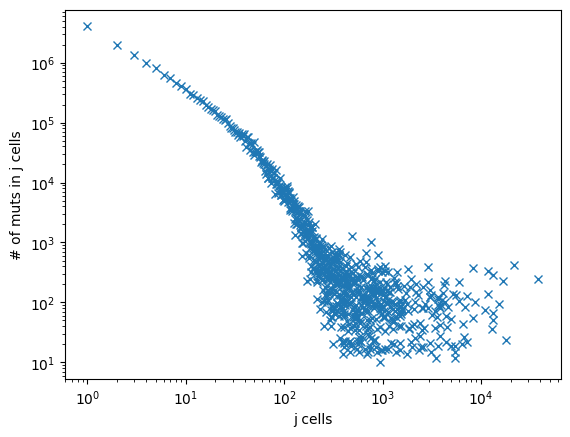

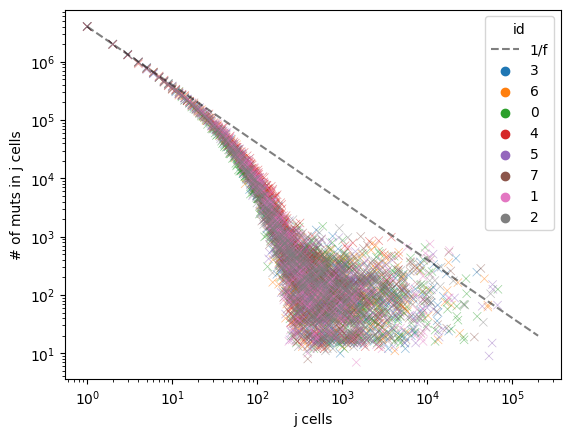

In [29]:
sfs_figures.show_sfs_last_timepoint_plots(sim_options_population, PLOT_OPTIONS)


loading mutational burden for age 0
skipping timepoint 21 with age 0 because empty sfs

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28

loading mutational burden for age 38
age 38 cannot be mapped, found mapping of timepoint 11 for the closest age of 40

loading mutational burden for age 48

loading mutational burden for age 63
age 63 cannot be mapped, found mapping of timepoint 5 for the closest age of 64

loading mutational burden for age 75
age 75 cannot be mapped, found mapping of timepoint 2 for the closest age of 76

loading mutational burden for age 81
age 81 cannot be mapped, found mapping of timepoint 1 for the closest age of 80
CPU times: user 2.42 s, sys: 179 ms, total: 2.6 s
Wall time: 2.47 s


/home/francesco/hscpy/src/hscpy/figures/sfs.py:120: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


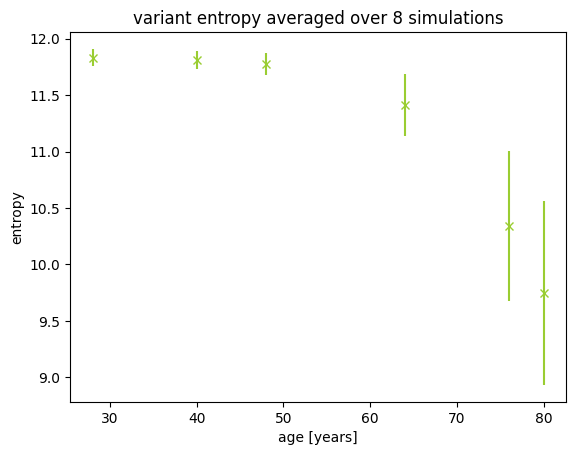

In [30]:
%%time
sfs_figures.show_entropy_plots(
    sim_options_population, PLOT_OPTIONS, mitchell_ages, early_variants_only=True
)


loading mutational burden for age 0

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28

loading mutational burden for age 38
age 38 cannot be mapped, found mapping of timepoint 11 for the closest age of 40

loading mutational burden for age 48

loading mutational burden for age 63
age 63 cannot be mapped, found mapping of timepoint 5 for the closest age of 64

loading mutational burden for age 75
age 75 cannot be mapped, found mapping of timepoint 2 for the closest age of 76

loading mutational burden for age 81
age 81 cannot be mapped, found mapping of timepoint 1 for the closest age of 80
CPU times: user 2min 36s, sys: 14.6 s, total: 2min 51s
Wall time: 2min 53s


/home/francesco/hscpy/src/hscpy/figures/sfs.py:120: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


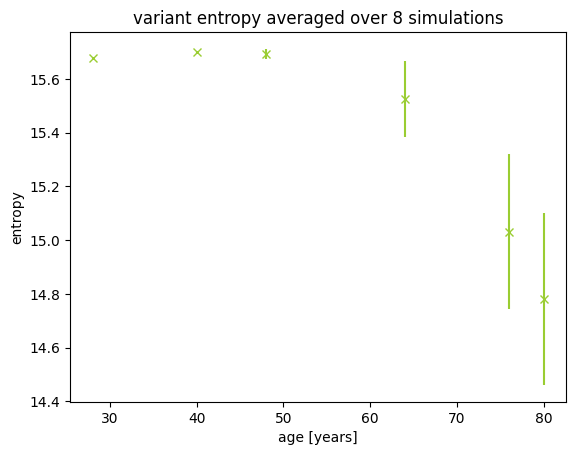

In [31]:
%%time
sfs_figures.show_entropy_plots(
    sim_options_population, PLOT_OPTIONS, mitchell_ages, early_variants_only=False
)


loading mutational burden for age 0
	 total mutational burden of 26 and 1 cells
	 total mutational burden of 18 and 1 cells
	 total mutational burden of 27 and 1 cells
	 total mutational burden of 17 and 1 cells
	 total mutational burden of 21 and 1 cells
	 total mutational burden of 14 and 1 cells
	 total mutational burden of 18 and 1 cells
	 total mutational burden of 21 and 1 cells

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28
	 total mutational burden of 112510295 and 200000 cells
	 total mutational burden of 112468549 and 200000 cells
	 total mutational burden of 112073418 and 200000 cells
	 total mutational burden of 112640593 and 200000 cells
	 total mutational burden of 112210468 and 200000 cells
	 total mutational burden of 112320431 and 200000 cells
	 total mutational burden of 112555249 and 200000 cells
	 total mutational burden of 112220010 and 200000 cells

loading mutational burden for age 38
age 38

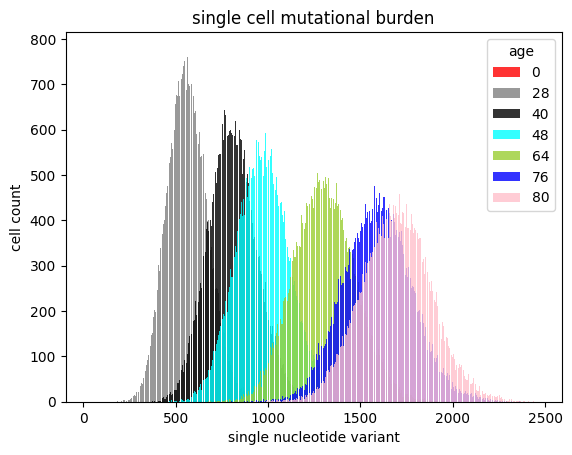

In [32]:
burden_figures.show_burden_plots(sim_options_population, PLOT_OPTIONS, mitchell_ages)

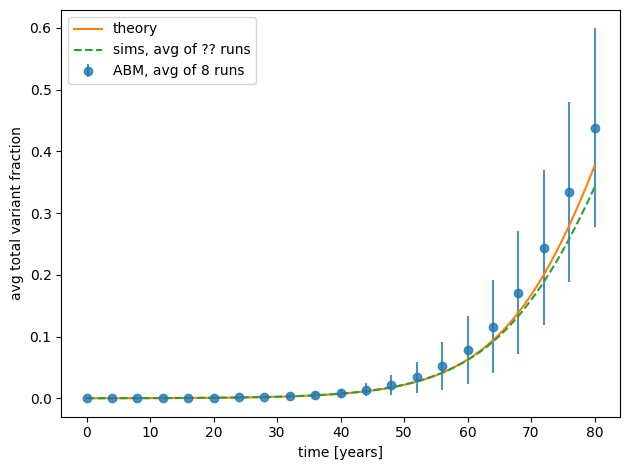

/home/francesco/hscpy/src/hscpy/figures/variant.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/hscpy/src/hscpy/figures/variant.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/venvs/hsc-draft/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/francesco/hscpy/src/hscpy/figures/variant.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  rl.fig.show()


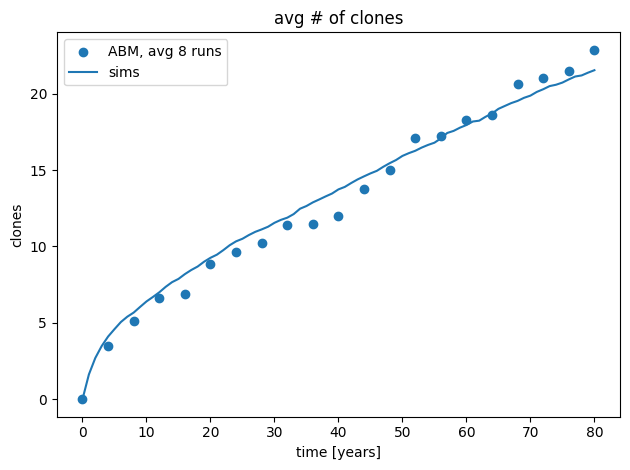

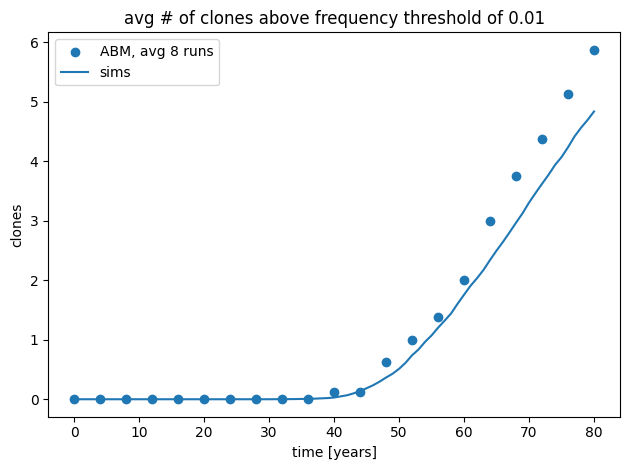

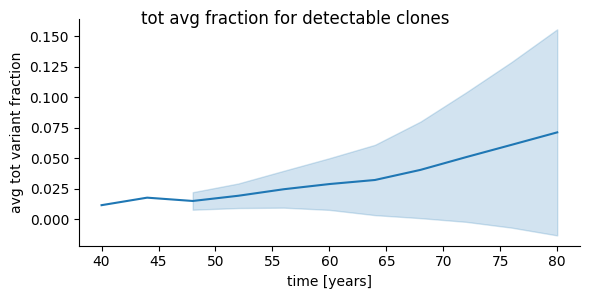

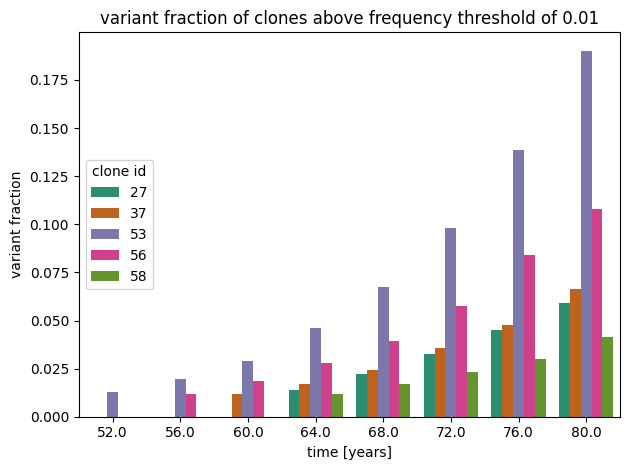

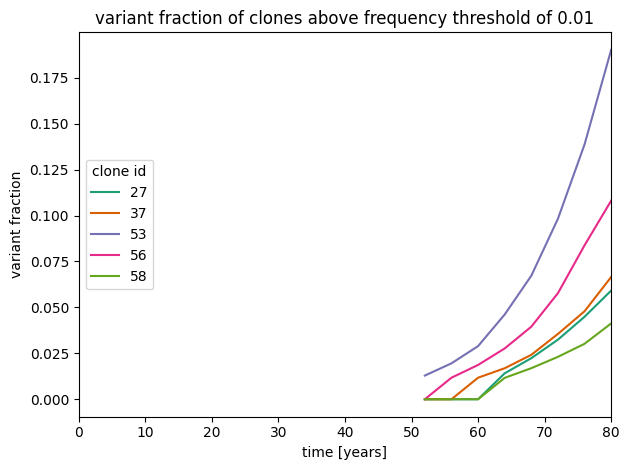

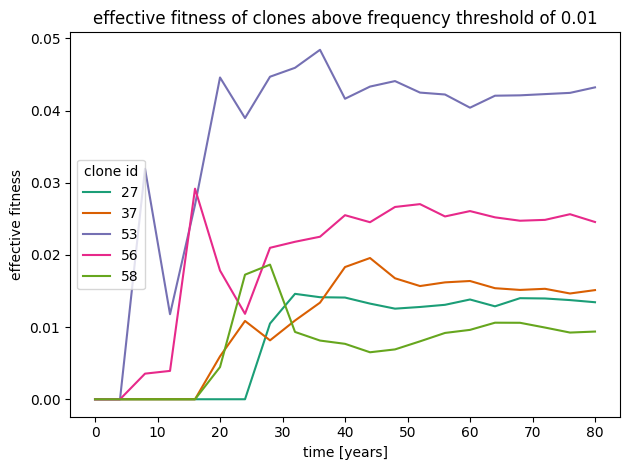

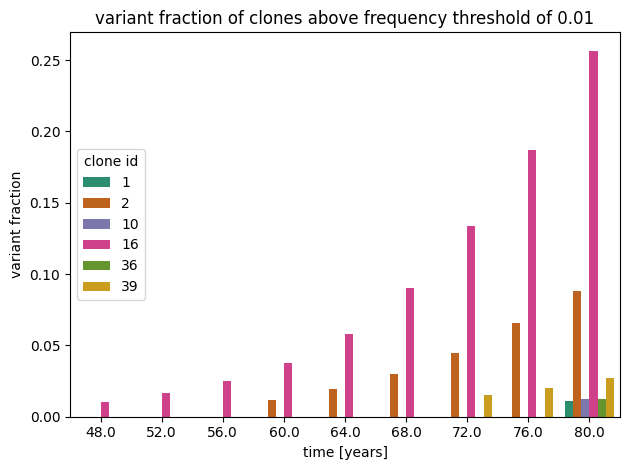

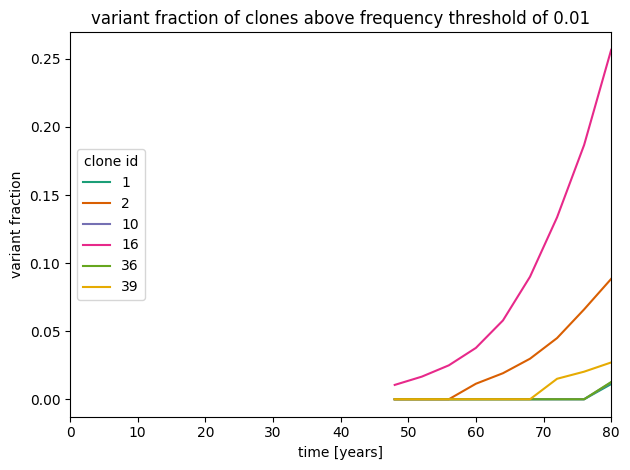

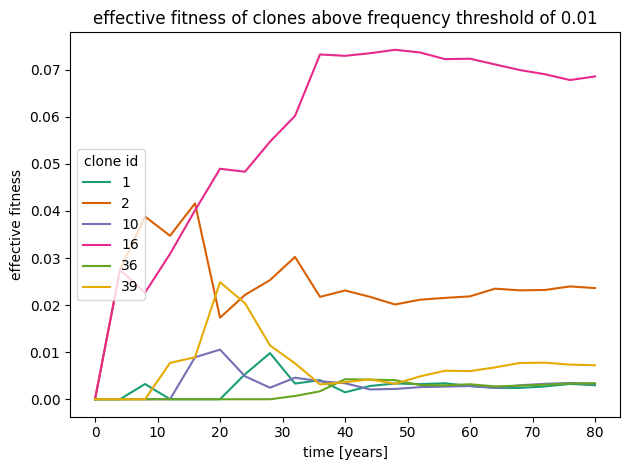

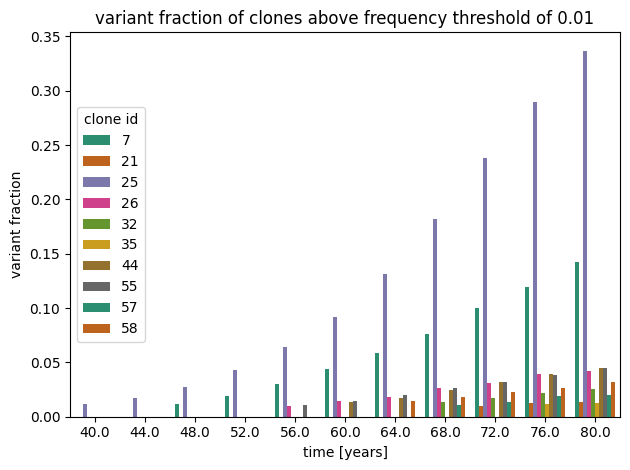

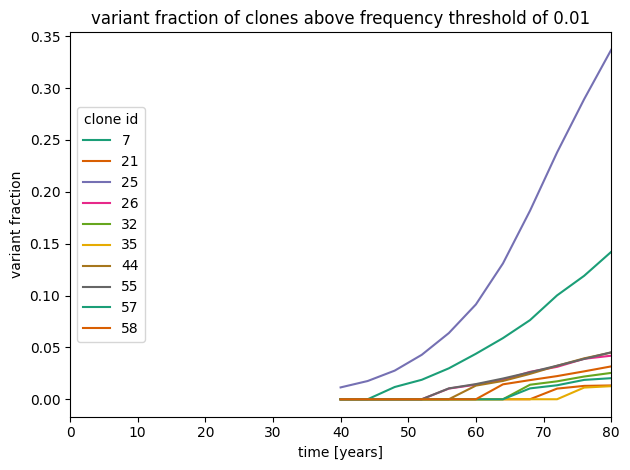

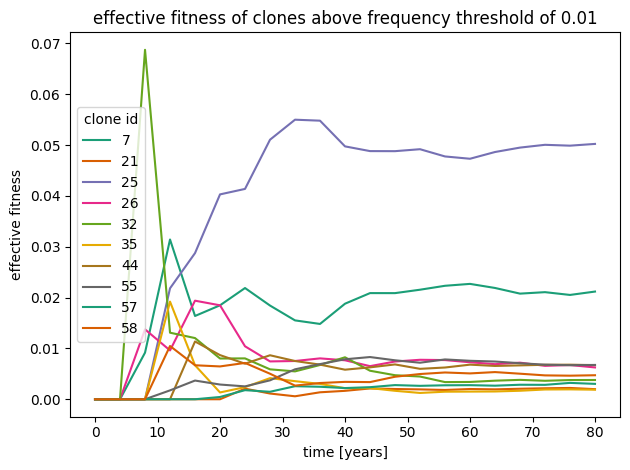

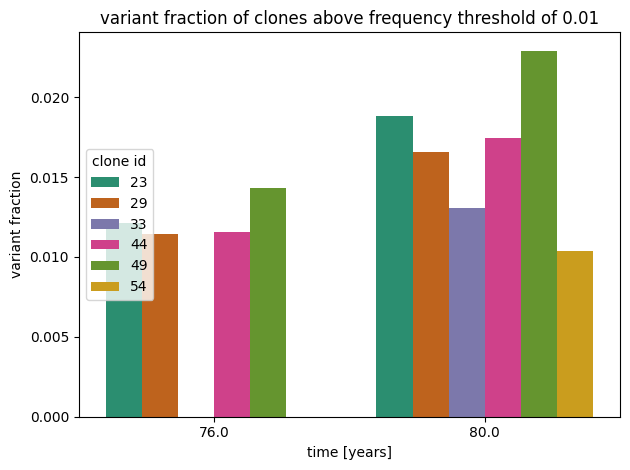

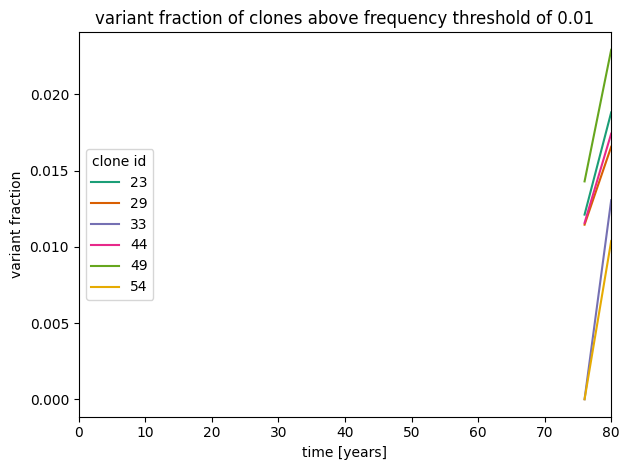

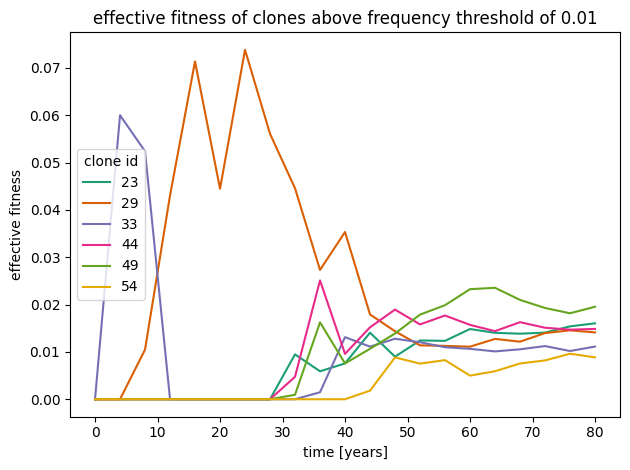

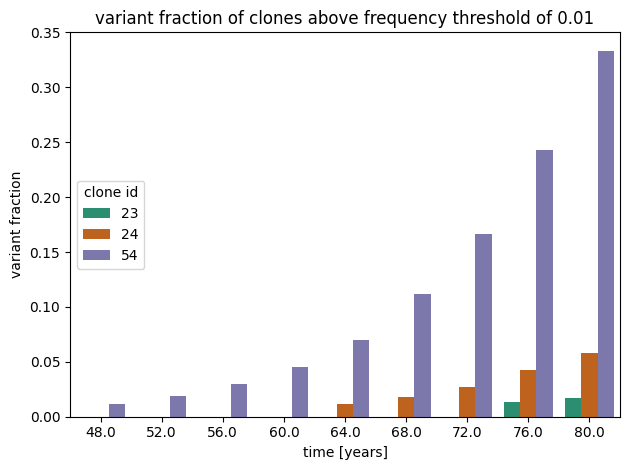

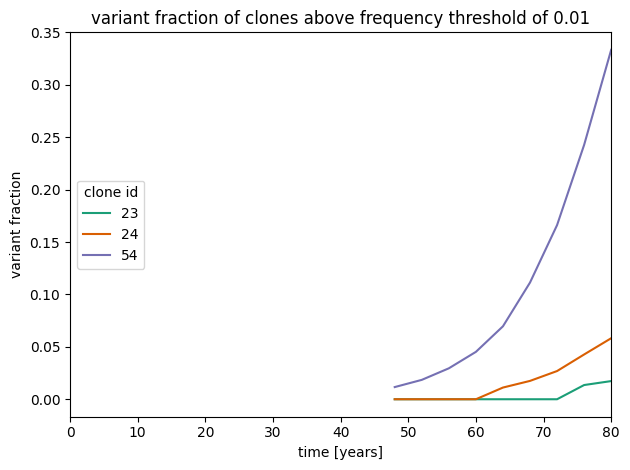

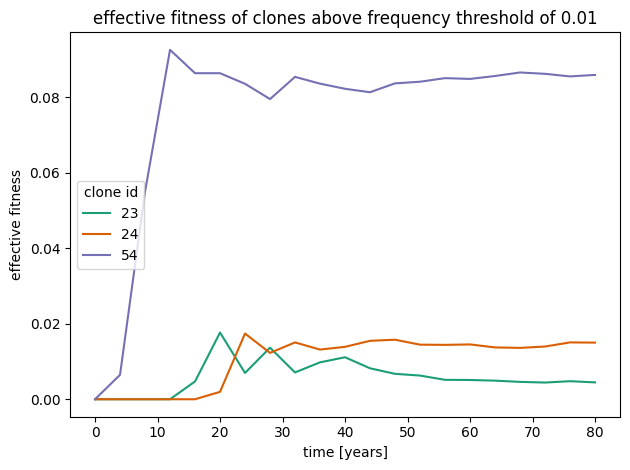

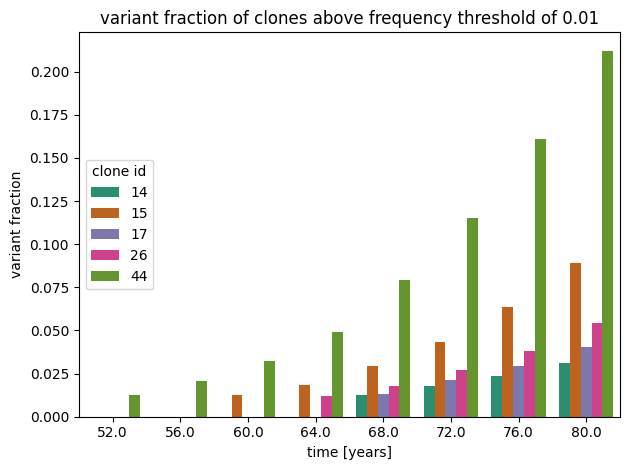

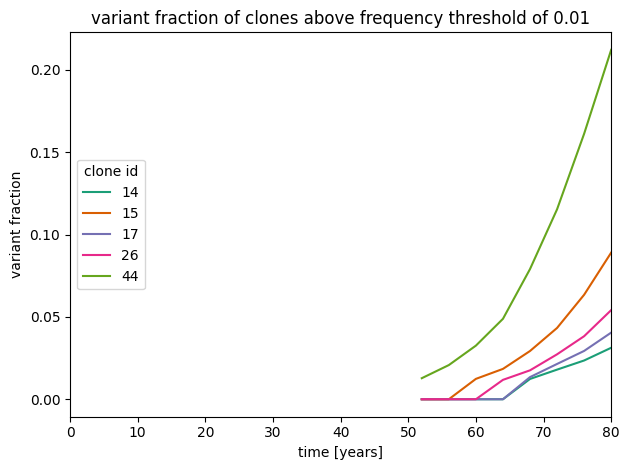

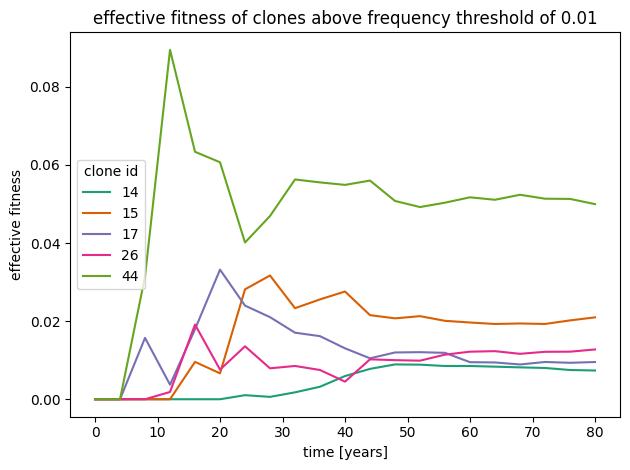

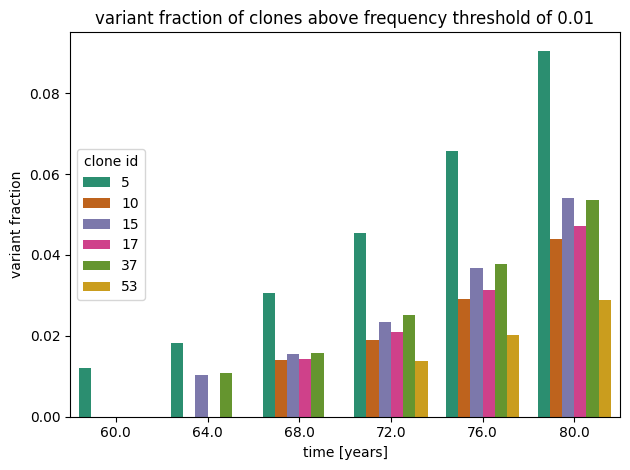

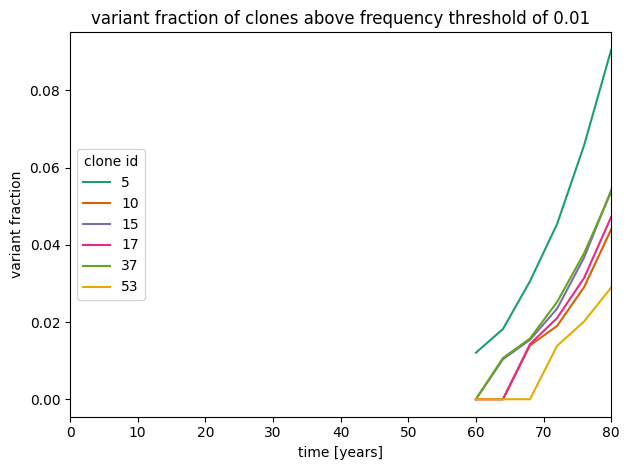

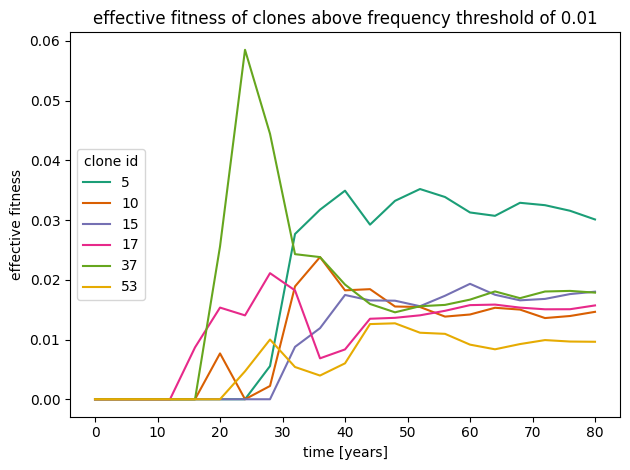

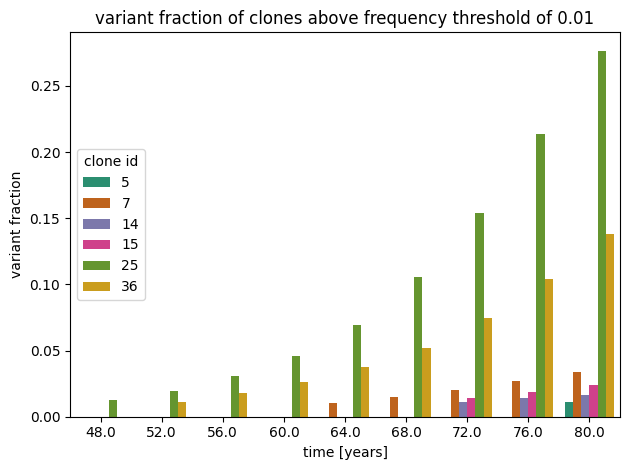

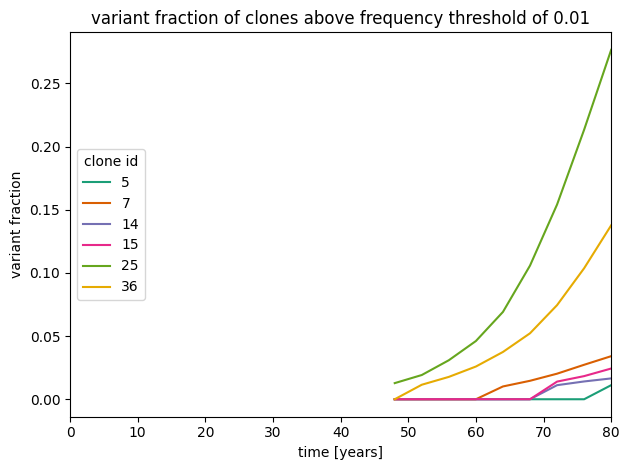

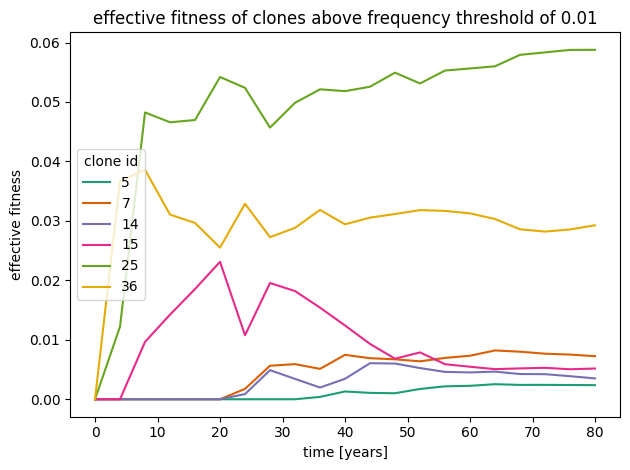

In [33]:
variant_figures.show_variant_plots(
    sim_options_population, PLOT_OPTIONS, PATH2SIMS, DETECTION_THRESH
)

### subsampling

/home/francesco/hscpy/src/hscpy/figures/sfs.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/hscpy/src/hscpy/figures/sfs.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


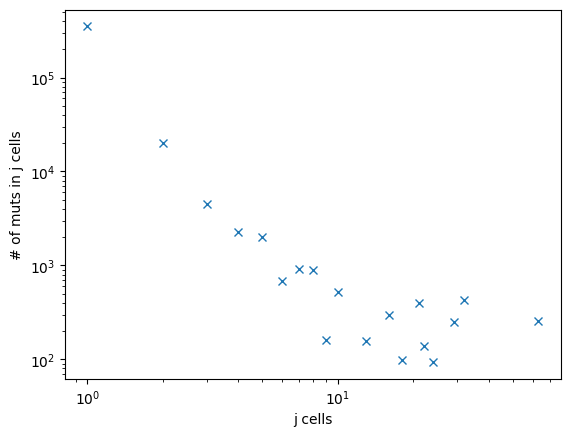

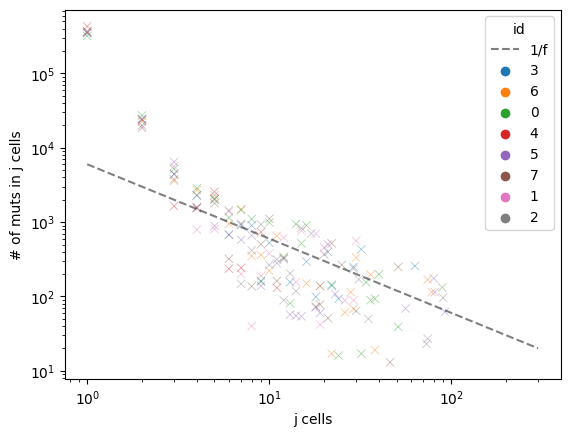

In [34]:
sfs_figures.show_sfs_last_timepoint_plots(sim_options_subsampling, PLOT_OPTIONS)


loading mutational burden for age 0
skipping timepoint 21 with age 0 because empty sfs

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28

loading mutational burden for age 38
age 38 cannot be mapped, found mapping of timepoint 11 for the closest age of 40

loading mutational burden for age 48

loading mutational burden for age 63
age 63 cannot be mapped, found mapping of timepoint 5 for the closest age of 64

loading mutational burden for age 75
age 75 cannot be mapped, found mapping of timepoint 2 for the closest age of 76

loading mutational burden for age 81
age 81 cannot be mapped, found mapping of timepoint 1 for the closest age of 80
CPU times: user 345 ms, sys: 82 ms, total: 427 ms
Wall time: 208 ms


/home/francesco/hscpy/src/hscpy/figures/sfs.py:120: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


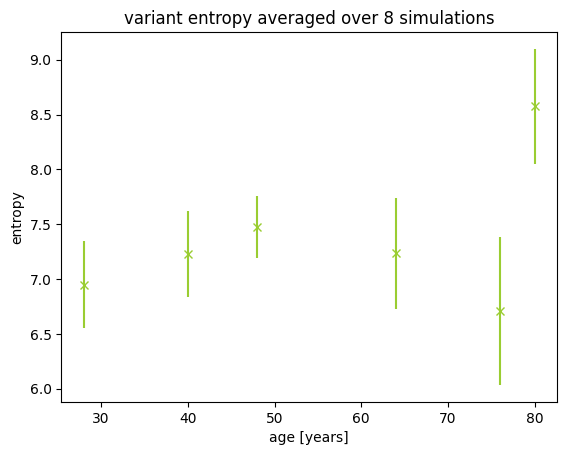

In [35]:
%%time
sfs_figures.show_entropy_plots(
    sim_options_subsampling, PLOT_OPTIONS, mitchell_ages, early_variants_only=True
)


loading mutational burden for age 0
skipping timepoint 21 with age 0 because empty sfs

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28

loading mutational burden for age 38
age 38 cannot be mapped, found mapping of timepoint 11 for the closest age of 40

loading mutational burden for age 48

loading mutational burden for age 63
age 63 cannot be mapped, found mapping of timepoint 5 for the closest age of 64

loading mutational burden for age 75
age 75 cannot be mapped, found mapping of timepoint 2 for the closest age of 76

loading mutational burden for age 81
age 81 cannot be mapped, found mapping of timepoint 1 for the closest age of 80
CPU times: user 2.72 s, sys: 165 ms, total: 2.89 s
Wall time: 2.73 s


/home/francesco/hscpy/src/hscpy/figures/sfs.py:120: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


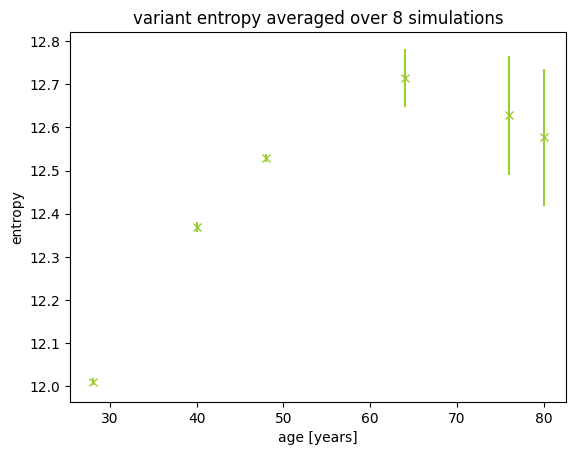

In [36]:
%%time
sfs_figures.show_entropy_plots(
    sim_options_subsampling, PLOT_OPTIONS, mitchell_ages, early_variants_only=False
)


loading mutational burden for age 0
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells
	 total mutational burden of 0 and 0 cells

loading mutational burden for age 29
age 29 cannot be mapped, found mapping of timepoint 14 for the closest age of 28
	 total mutational burden of 167016 and 300 cells
	 total mutational burden of 170385 and 300 cells
	 total mutational burden of 167008 and 300 cells
	 total mutational burden of 171520 and 300 cells
	 total mutational burden of 170803 and 300 cells
	 total mutational burden of 168913 and 300 cells
	 total mutational burden of 170147 and 300 cells
	 total mutational burden of 167226 and 300 cells

loading mutational burden for age 38
age 38 cannot be mapped, found mapping of timepoint 11 for the

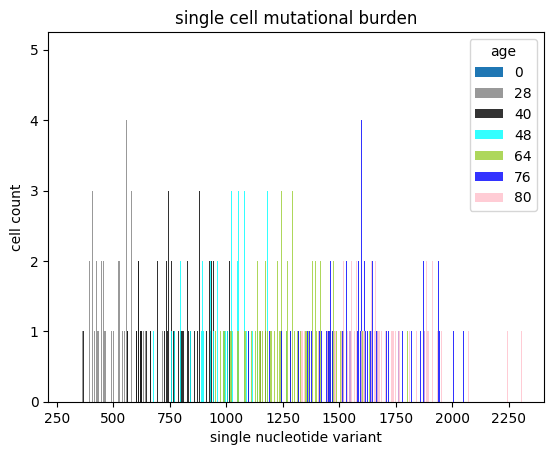

In [37]:
burden_figures.show_burden_plots(sim_options_subsampling, PLOT_OPTIONS, mitchell_ages)

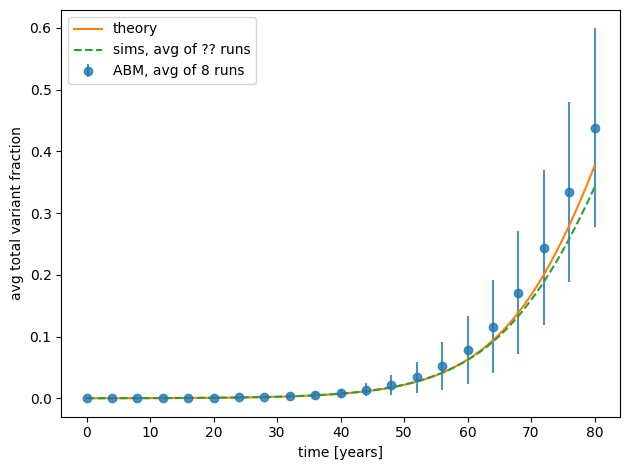

/home/francesco/hscpy/src/hscpy/figures/variant.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/hscpy/src/hscpy/figures/variant.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/francesco/venvs/hsc-draft/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/francesco/hscpy/src/hscpy/figures/variant.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  rl.fig.show()


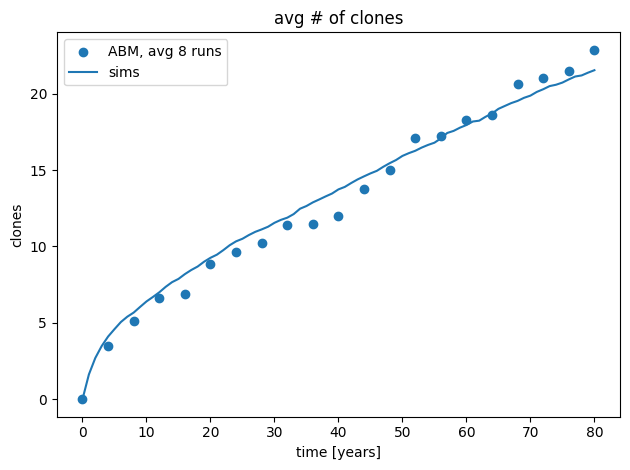

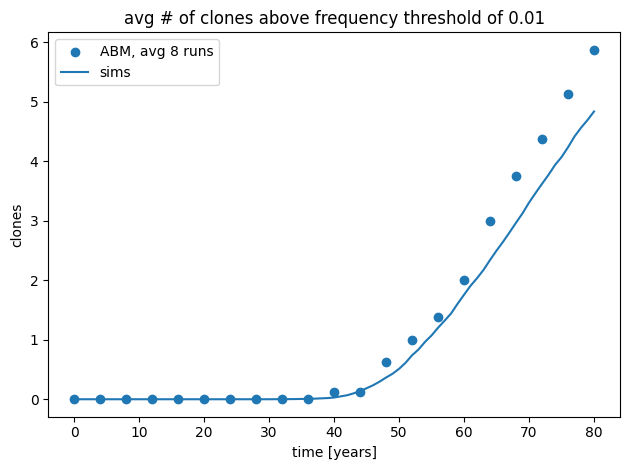

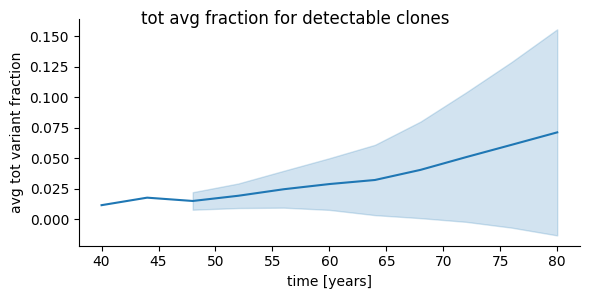

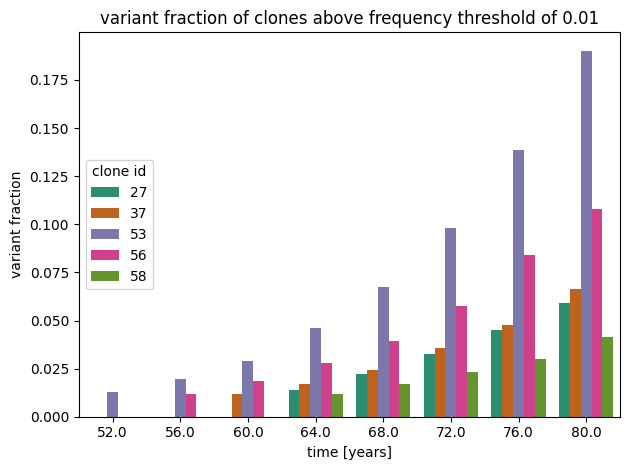

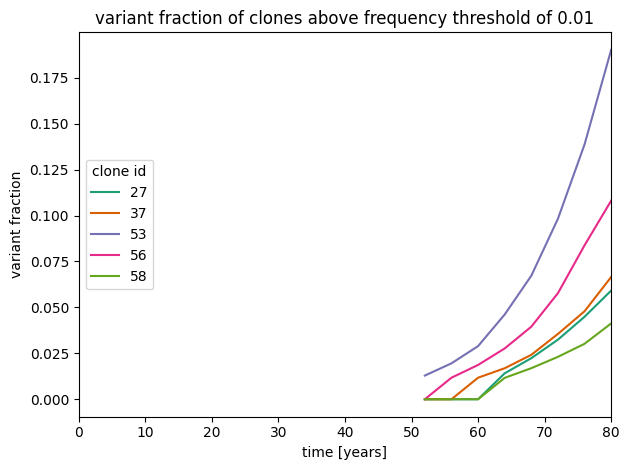

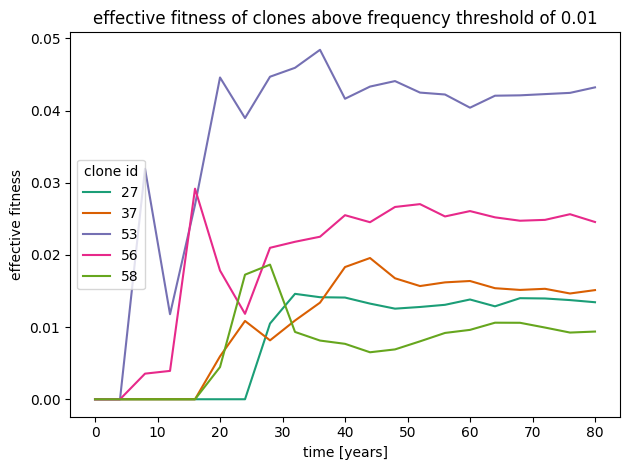

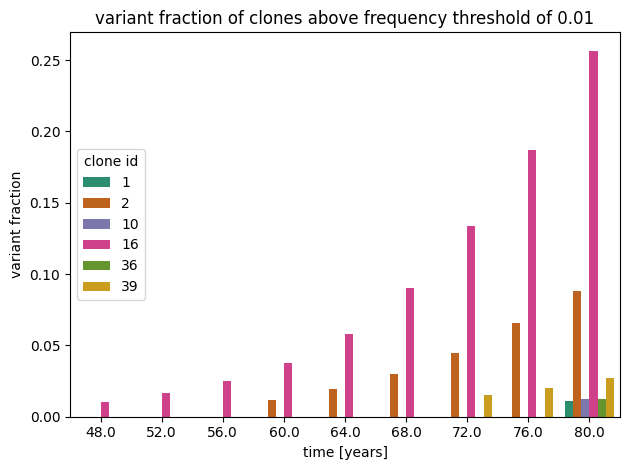

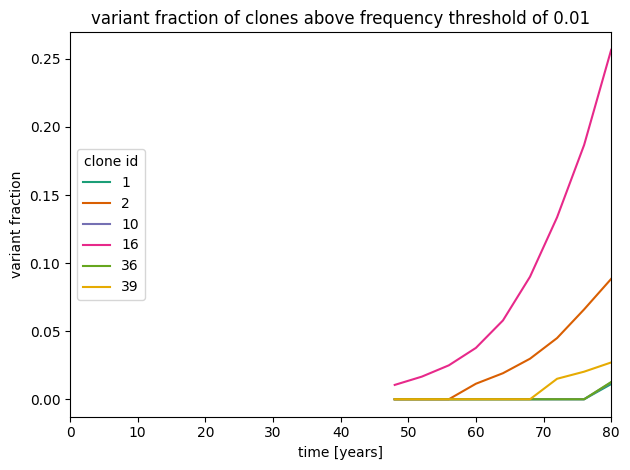

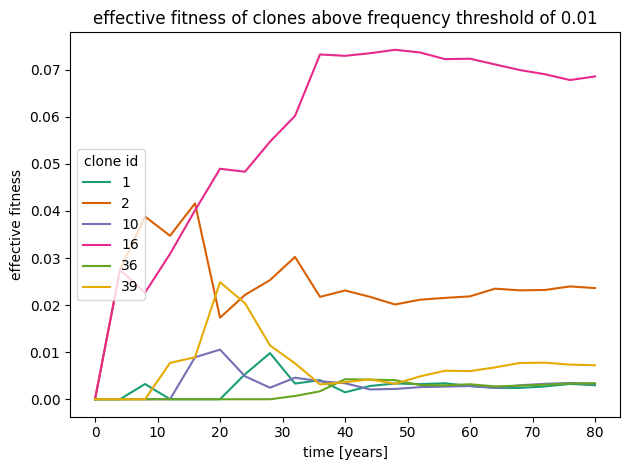

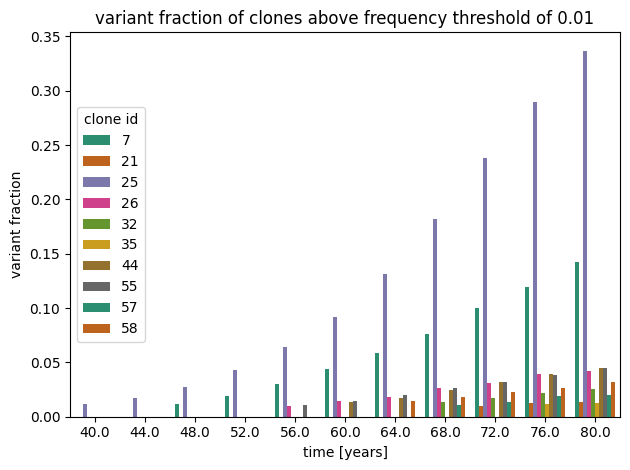

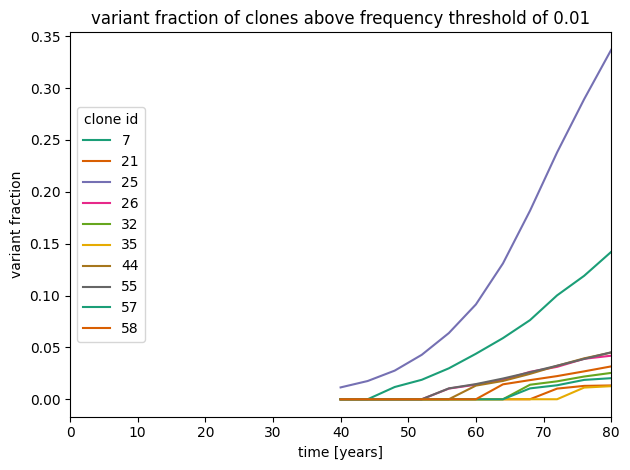

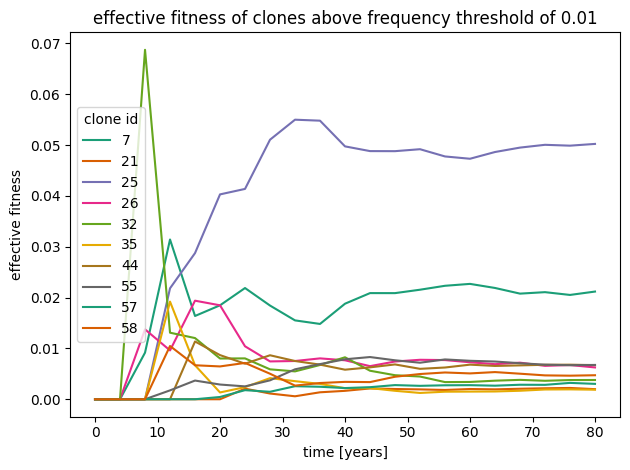

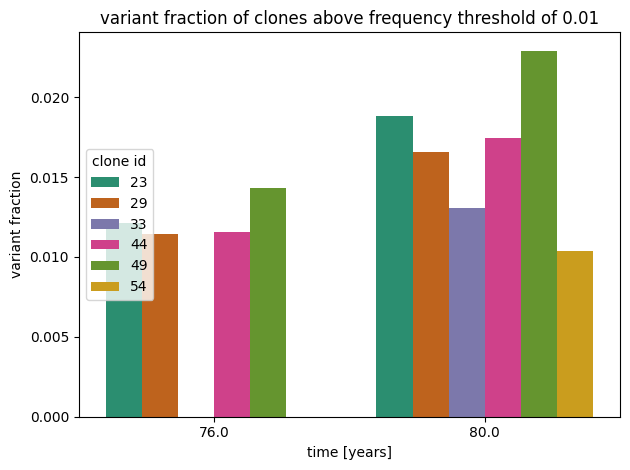

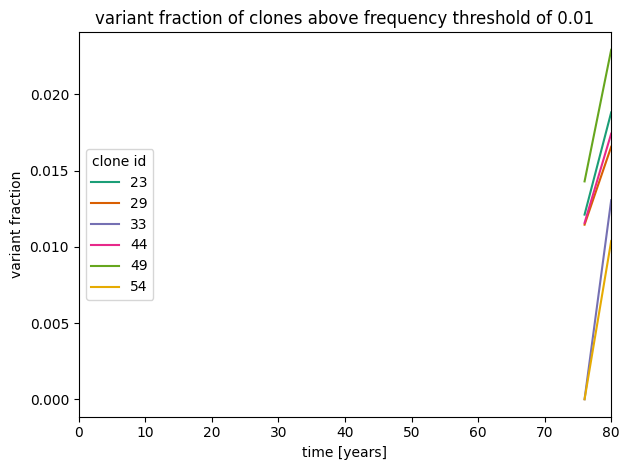

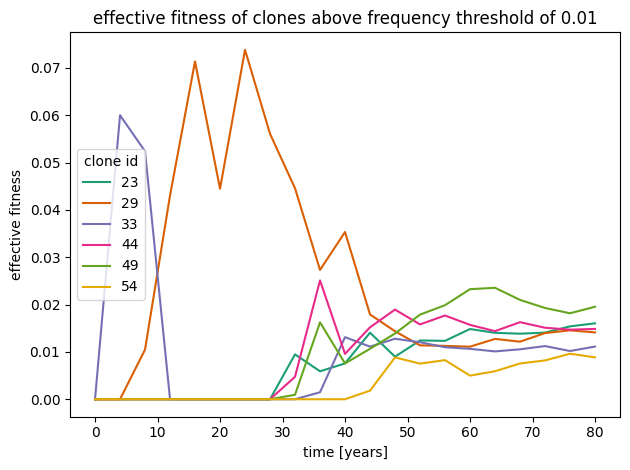

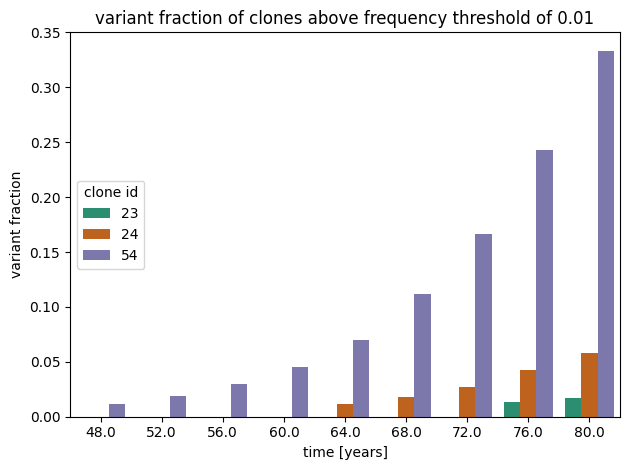

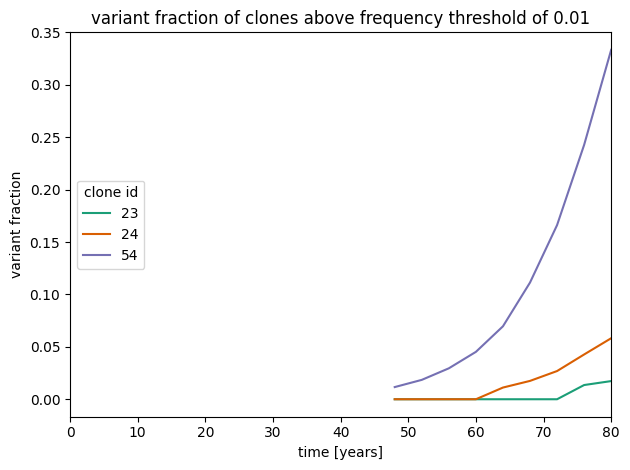

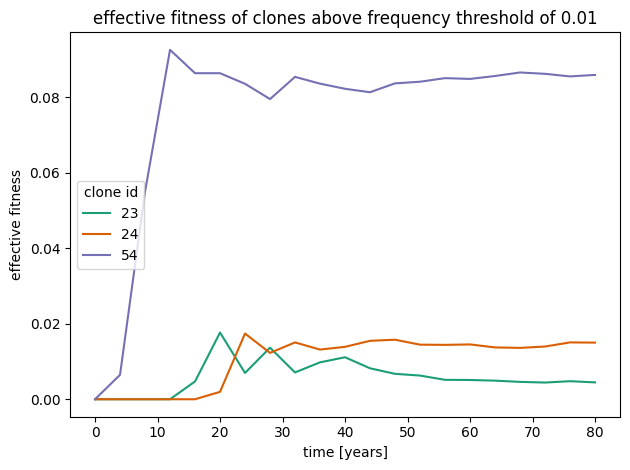

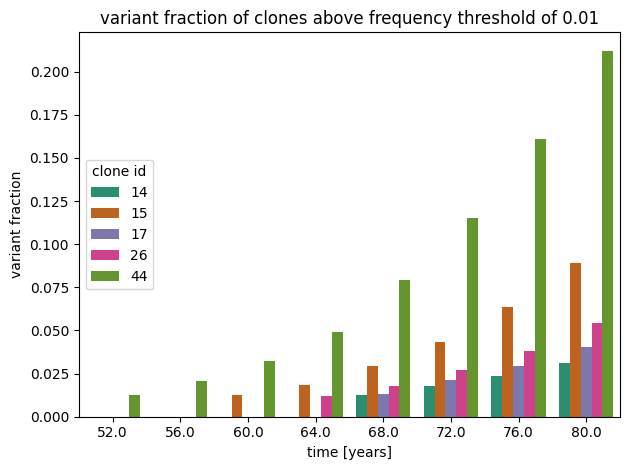

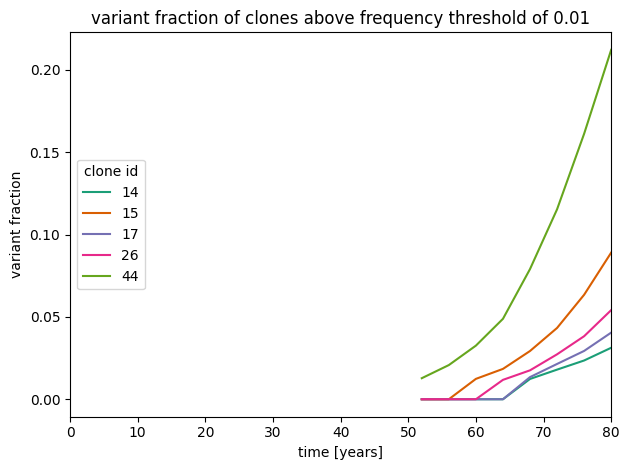

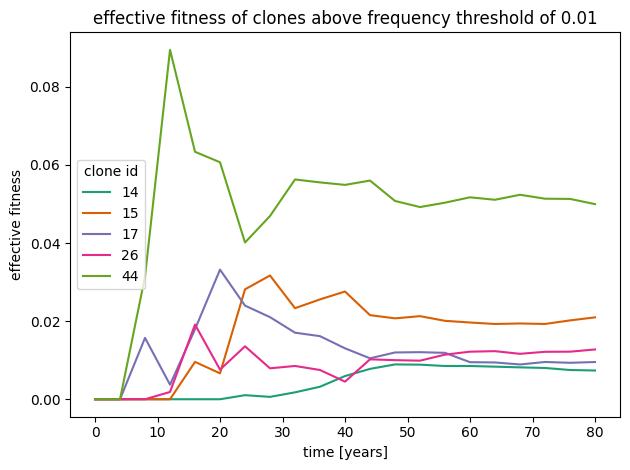

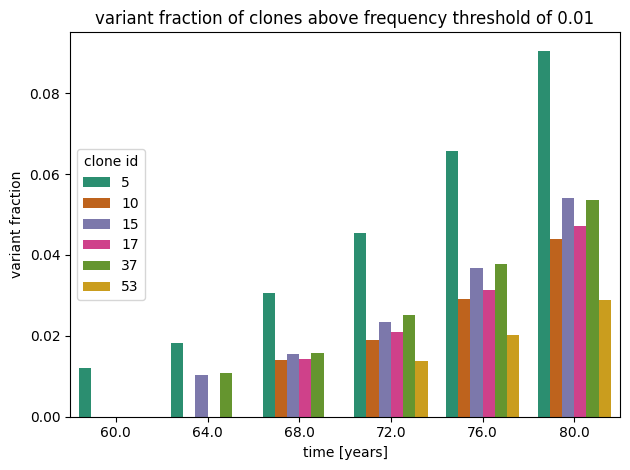

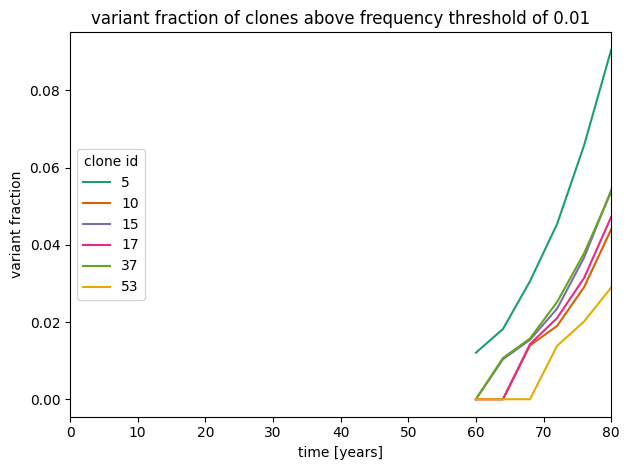

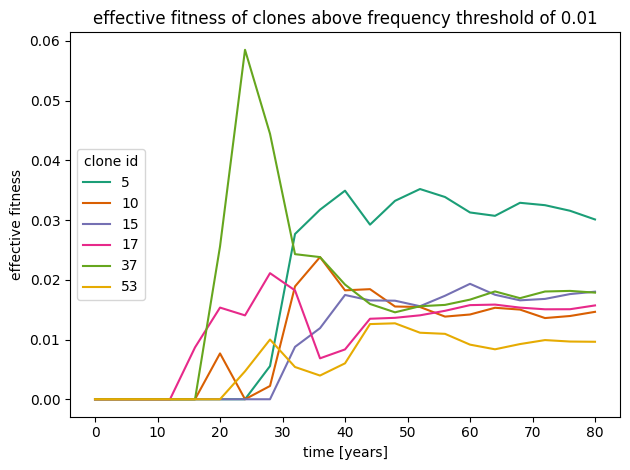

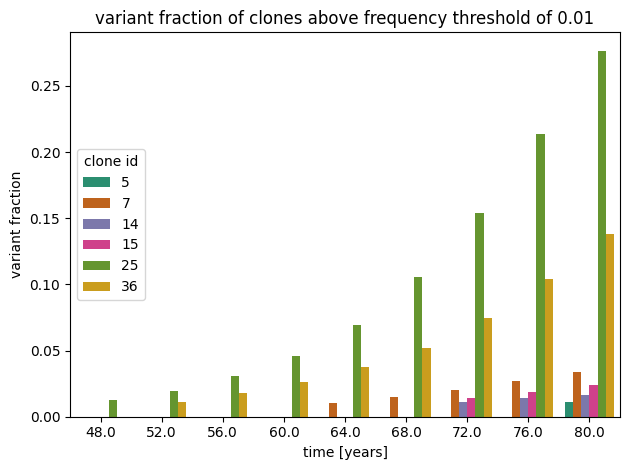

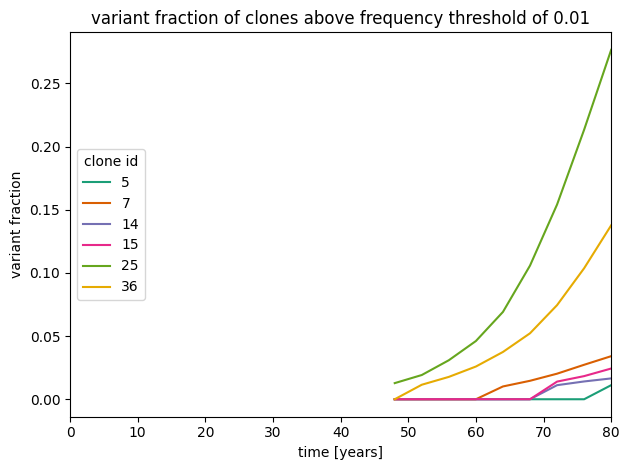

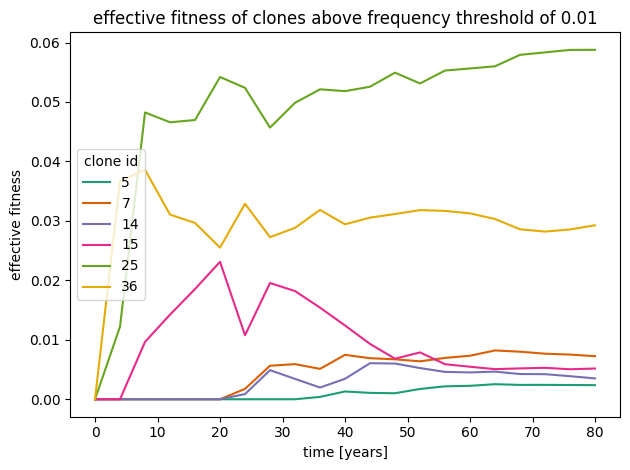

In [38]:
variant_figures.show_variant_plots(
    sim_options_subsampling, PLOT_OPTIONS, PATH2SIMS, DETECTION_THRESH
)

## Competition vs neutral vs 1 clone (logistic fn)

In [ ]:
# TODO 1 clone logistic fn